In [1]:
using LinearAlgebra

In [2]:
mutable struct _H
    LR::Matrix{Float64} # 线性作用参数
    NLR::Matrix{Float64} # 非线性相互作用参数
    Ĥ::Matrix{Float64}
end
function _H(wp::Int64, Fockdims::Int64)
    return _H(zeros(wp, wp), zeros(wp, wp), zeros(Fockdims, Fockdims))
end

_H

In [3]:
mutable struct _U
    t::Float64
    Û::Matrix{ComplexF64}
end
function _U(Fockdims::Int64)
    return _U(0, Matrix{ComplexF64}(I, Fockdims, Fockdims))
end

_U

In [4]:
struct SecondQuantizationSystem
    Well::Int64 # 势阱数量
    PC::Int64 # 粒子种类
    N::Int64 # 粒子总数
    Fockdims::Int64 # Fock基数量
    Fock::Matrix{Int64} # 各势阱粒子数形式Fock基矩阵
    Focki::Matrix{Int64} # 编号形式Fock基矩阵
    n̂::Vector{Matrix{Int64}} # 粒子数算符列表
    â⁺â::Matrix{Matrix{Float64}} # 生成湮灭算符列表
    state::Vector{ComplexF64} # 系统态矢量
    H::_H # 哈密顿描述结构
    U::_U # 时间演化描述结构
end

In [5]:
function Nloop!(Fock::Matrix{Int64},WP::Int64, N::Int64)
    forlist = zeros(3, WP-1) # forlist[1,:] start; forlist[2,:] end; forlist[3,:] value
    forlist[2,:] = fill(N, WP-1)
    forlay = WP-1
    i= 1
    while forlist[3,1] <= forlist[2,1]
        Fock[i,:] = [forlist[3,:]; N-sum(forlist[3,:])]
        i += 1
        forlist[3, forlay] += 1
        if forlist[3, forlay] > forlist[2, forlay]
            while forlist[3, forlay] > forlist[2, forlay] && forlay > 1
                forlist[3, forlay] = 0
                forlay -= 1
                forlist[3, forlay] += 1
            end
            while forlay != WP-1
                forlist[2, forlay+1] = N-sum(forlist[3,1:forlay])
                forlay += 1
            end
        end
    #     if N-sum(forlist[3,:]) < 0
    #         break;
    #     end
    end
    return Fock
end

Nloop! (generic function with 1 method)

In [6]:
function SecondQuantizationSystem(Well::Int64, PC::Int64, N::Int64)
    WP = Well*PC
    Fockdims = binomial(N+WP-1, WP-1)
    Fock =  Matrix{Int64}(undef, Fockdims, WP)
    Nloop!(Fock, WP, N)
    Focki = Matrix{Int64}(I, Fockdims, Fockdims)
    n̂ = Vector{Matrix{Int64}}(undef, WP)
    â⁺â = Matrix{Matrix{Float64}}(undef, WP, WP)
    for i = 1:WP
        n̂[i] = diagm(Fock[:,i])
    end
    for m = 1:WP, n = 1:WP
        if m != n
            â⁺â[m,n] = zeros(Fockdims, Fockdims)
            for i = 1:Fockdims, j = 1:Fockdims
                if Fock[i,m] == (Fock[j,m]+1) && Fock[i,n] == (Fock[j,n]-1)
                    â⁺â[m,n][i,j] = sqrt(Fock[i,m])*sqrt(Fock[j,n])
                end
            end
        else
            â⁺â[m,n] = n̂[m]
        end
    end
    state = ComplexF64.(Focki[:,1])
    this = SecondQuantizationSystem(Well, PC, N, Fockdims, Fock, Focki, n̂, â⁺â, state, _H(WP, Fockdims), _U(Fockdims))
    return this
end

SecondQuantizationSystem

In [7]:
function U!(this::SecondQuantizationSystem, t)
    if this.U.t == t
        return this.U.Û
    end
    this.U.t = t
    this.U.Û = exp(-im*this.H.Ĥ*t)
    return this.U.Û
end

U! (generic function with 1 method)

In [31]:
function H!(this::SecondQuantizationSystem, LR::Matrix, NLR::Matrix)
    if this.H.LR == LR && this.H.NLR == NLR
        return this.H.Ĥ
    end
    this.H.LR, this.H.NLR = LR, NLR
    n̂, â⁺â, FD, WP = this.n̂, this.â⁺â, this.Fockdims, this.Well*this.PC
    Ĥ = zeros(FD, FD)
    for i = 1:WP, j = 1:WP
        Ĥ += LR[i,j]*â⁺â[i,j]
        if i == j
            Ĥ += NLR[i,i]*(n̂[i]*(n̂[i].-1))/2
        else
            Ĥ += NLR[i,j]*(n̂[i]*n̂[j])/2
        end
    end
    this.H.Ĥ = Ĥ
end

H! (generic function with 1 method)

In [99]:
function FockState!(this::SecondQuantizationSystem, aim::Vector{Int64})
    for i = 1:this.Fockdims
        if this.Fock[i,:] == aim
            this.state .= this.Focki[:,i]
            return true
        end
    end
    return false
end

FockState! (generic function with 1 method)

In [10]:
function CoherentState!(
        this::SecondQuantizationSystem;
        P::Vector=[],
        phi::Vector=[],
    )
    N, Fockdims, Fock, state, WP = this.N, this.Fockdims, this.Fock, this.state, this.Well*this.PC
    if P == []
        P = ones(WP)
    elseif length(P) != WP
        return false
    end
    if phi == []
        phi = zeros(WP)
    elseif length(phi) != WP
        return false
    end
    P = sqrt.(P./sum(P))
    NC = sqrt(factorial(N))
    fill!(state, 1.0+0.0im)
    for i = 1:Fockdims
        state[i] *= NC/sqrt(prod(factorial.(Fock[i,:])))
        for j = 1:WP
            state[i] *= (P[j]*exp(im*phi[j]))^Fock[i,j]
        end
    end
    return true
end
function CSTest(this::SecondQuantizationSystem)
    N, x, n̂, WP = this.N, this.state, this.n̂, this.Well*this.PC
    for i = 1:WP
        println("P_$(i)：",x'*(n̂[i]/N)*x)
    end
    return nothing
end

CSTest (generic function with 1 method)

In [15]:
function HforS_3_1(this::SecondQuantizationSystem,nu, c, gamma)
    LR = [
        gamma nu/2 nu/2
        nu/2  0    nu/2
        nu/2  nu/2 -gamma
    ]
    NLR = [
        -c/2 0    0
        0    -c/2 0
        0    0    -c/2
    ]
    H!(this, LR, NLR)
end

HforS_3_1 (generic function with 1 method)

In [37]:
using PyPlot

In [53]:
function Dynamics(
        this;
        Draw = true,
        SaveFig = true,
        tUnit = 1,
        tSpan = (0,300),
    )
    span = tSpan[1]*tUnit:tUnit:tSpan[2]*tUnit
    n̂, WP = this.n̂, this.Well*this.PC
    data = Matrix{ComplexF64}(undef, length(span), WP+1)
    for (t,i) = zip(span,1:length(span))
        U!(this, t)
        ψ = this.U.Û*this.state
        data[i,1] = t
        for j = 1:WP
            data[i,j+1] = ψ'*n̂[j]*ψ
        end
    end
    if Draw
        H = this.H
        figure(figsize=(16,9))
        plot(data[:,1], data[:,2:end], label=["$(i)" for i = 1:WP])
        xlabel("\$t\$")
        ylabel("\$n\$")
        title("n-t_LR$(round.(H.LR,digits=2))NLR$(round.(H.NLR,digits=2))Sta$(round.(data[1,2:end],digits=0))")
        legend()
        # ax = gca(projection="3d")
        # ax[:view_init](45,45)
        if SaveFig
            savefig("n-t_LR$(round.(H.LR,digits=2))NLR$(round.(H.NLR,digits=2))Sta$(round.(data[1,2:end],digits=0)).pdf")
            savefig("n-t_LR$(round.(H.LR,digits=2))NLR$(round.(H.NLR,digits=2))Sta$(round.(data[1,2:end],digits=0)).svg")
        end
    end
    return data
end

Dynamics (generic function with 1 method)

In [9]:
S_3_1_10 = SecondQuantizationSystem(1,3,10)

SecondQuantizationSystem(1, 3, 10, 66, [0 0 10; 0 1 9; … ; 9 1 0; 10 0 0], [1 0 … 0 0; 0 1 … 0 0; … ; 0 0 … 1 0; 0 0 … 0 1], [[0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 9 0; 0 0 … 0 10], [0 0 … 0 0; 0 1 … 0 0; … ; 0 0 … 1 0; 0 0 … 0 0], [10 0 … 0 0; 0 9 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0]], [[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 9.0 0.0; 0.0 0.0 … 0.0 10.0] [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 3.1622776601683795 0.0] [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]; [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 3.1622776601683795; 0.0 0.0 … 0.0 0.0] [0.0 0.0 … 0.0 0.0; 0.0 1.0 … 0.0 0.0; … ; 0.0 0.0 … 1.0 0.0; 0.0 0.0 … 0.0 0.0] [0.0 0.0 … 0.0 0.0; 3.1622776601683795 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]; [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0] [0.0 3.1622776601683795 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0] [10.0 0.0

In [91]:
S_3_1_8 = SecondQuantizationSystem(1,3,8)

SecondQuantizationSystem(1, 3, 8, 45, [0 0 8; 0 1 7; … ; 7 1 0; 8 0 0], [1 0 … 0 0; 0 1 … 0 0; … ; 0 0 … 1 0; 0 0 … 0 1], [[0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 7 0; 0 0 … 0 8], [0 0 … 0 0; 0 1 … 0 0; … ; 0 0 … 1 0; 0 0 … 0 0], [8 0 … 0 0; 0 7 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0]], [[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 7.0 0.0; 0.0 0.0 … 0.0 8.0] [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 2.8284271247461903 0.0] [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]; [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 2.8284271247461903; 0.0 0.0 … 0.0 0.0] [0.0 0.0 … 0.0 0.0; 0.0 1.0 … 0.0 0.0; … ; 0.0 0.0 … 1.0 0.0; 0.0 0.0 … 0.0 0.0] [0.0 0.0 … 0.0 0.0; 2.8284271247461903 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]; [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0] [0.0 2.8284271247461903 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0] [8.0 0.0 … 0.0 

In [96]:
S_3_1_6 = SecondQuantizationSystem(1,3,6)

SecondQuantizationSystem(1, 3, 6, 28, [0 0 6; 0 1 5; … ; 5 1 0; 6 0 0], [1 0 … 0 0; 0 1 … 0 0; … ; 0 0 … 1 0; 0 0 … 0 1], [[0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 5 0; 0 0 … 0 6], [0 0 … 0 0; 0 1 … 0 0; … ; 0 0 … 1 0; 0 0 … 0 0], [6 0 … 0 0; 0 5 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0]], [[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 5.0 0.0; 0.0 0.0 … 0.0 6.0] [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 2.449489742783178 0.0] [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]; [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 2.449489742783178; 0.0 0.0 … 0.0 0.0] [0.0 0.0 … 0.0 0.0; 0.0 1.0 … 0.0 0.0; … ; 0.0 0.0 … 1.0 0.0; 0.0 0.0 … 0.0 0.0] [0.0 0.0 … 0.0 0.0; 2.449489742783178 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]; [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0] [0.0 2.449489742783178 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0] [6.0 0.0 … 0.0 0.0;

In [54]:
HforS_3_1(S_3_1_10, .1, .1, .1)

66×66 Matrix{Float64}:
 -3.25       0.408114   0.25      …   0.25       0.25       0.25
  0.408114  -2.7        0.462132      0.25       0.25       0.25
  0.25       0.462132  -2.25          0.25       0.25       0.25
  0.25       0.25       0.494949      0.25       0.25       0.25
  0.25       0.25       0.25          0.25       0.25       0.25
  0.25       0.25       0.25      …   0.25       0.25       0.25
  0.25       0.25       0.25          0.25       0.25       0.25
  0.25       0.25       0.25          0.25       0.25       0.25
  0.25       0.25       0.25          0.25       0.25       0.25
  0.25       0.25       0.25          0.25       0.25       0.25
  0.25       0.25       0.25      …   0.25       0.25       0.25
  0.408114   0.3        0.25          0.25       0.25       0.25
  0.25       0.4        0.320711      0.25       0.25       0.25
  ⋮                               ⋱                         ⋮
  0.25       0.25       0.25          0.25       0.25       0.25
  0.2

In [92]:
HforS_3_1(S_3_1_8, .1, .1, .1)

45×45 Matrix{Float64}:
 -2.2        0.341421   0.2       …   0.2        0.2        0.2
  0.341421  -1.75       0.387083      0.2        0.2        0.2
  0.2        0.387083  -1.4           0.2        0.2        0.2
  0.2        0.2        0.412132      0.2        0.2        0.2
  0.2        0.2        0.2           0.2        0.2        0.2
  0.2        0.2        0.2       …   0.2        0.2        0.2
  0.2        0.2        0.2           0.2        0.2        0.2
  0.2        0.2        0.2           0.2        0.2        0.2
  0.2        0.2        0.2           0.2        0.2        0.2
  0.341421   0.25       0.2           0.2        0.2        0.2
  0.2        0.332288   0.270711  …   0.2        0.2        0.2
  0.2        0.2        0.322474      0.2        0.2        0.2
  0.2        0.2        0.2           0.2        0.2        0.2
  ⋮                               ⋱                        
  0.2        0.2        0.2           0.2        0.2        0.2
  0.2        0.2     

In [97]:
HforS_3_1(S_3_1_6, .1, .1, .1)

28×28 Matrix{Float64}:
 -1.35       0.272474   0.15      …   0.15      0.15       0.15
  0.272474  -1.0        0.308114      0.15      0.15       0.15
  0.15       0.308114  -0.75          0.15      0.15       0.15
  0.15       0.15       0.323205      0.15      0.15       0.15
  0.15       0.15       0.15          0.15      0.15       0.15
  0.15       0.15       0.15      …   0.15      0.15       0.15
  0.15       0.15       0.15          0.15      0.15       0.15
  0.272474   0.2        0.15          0.15      0.15       0.15
  0.15       0.261803   0.220711      0.15      0.15       0.15
  0.15       0.15       0.25          0.15      0.15       0.15
  0.15       0.15       0.15      …   0.15      0.15       0.15
  0.15       0.15       0.15          0.15      0.15       0.15
  0.15       0.15       0.15          0.15      0.15       0.15
  ⋮                               ⋱   ⋮                   
  0.15       0.15       0.15          0.15      0.15       0.15
  0.15       0.15     

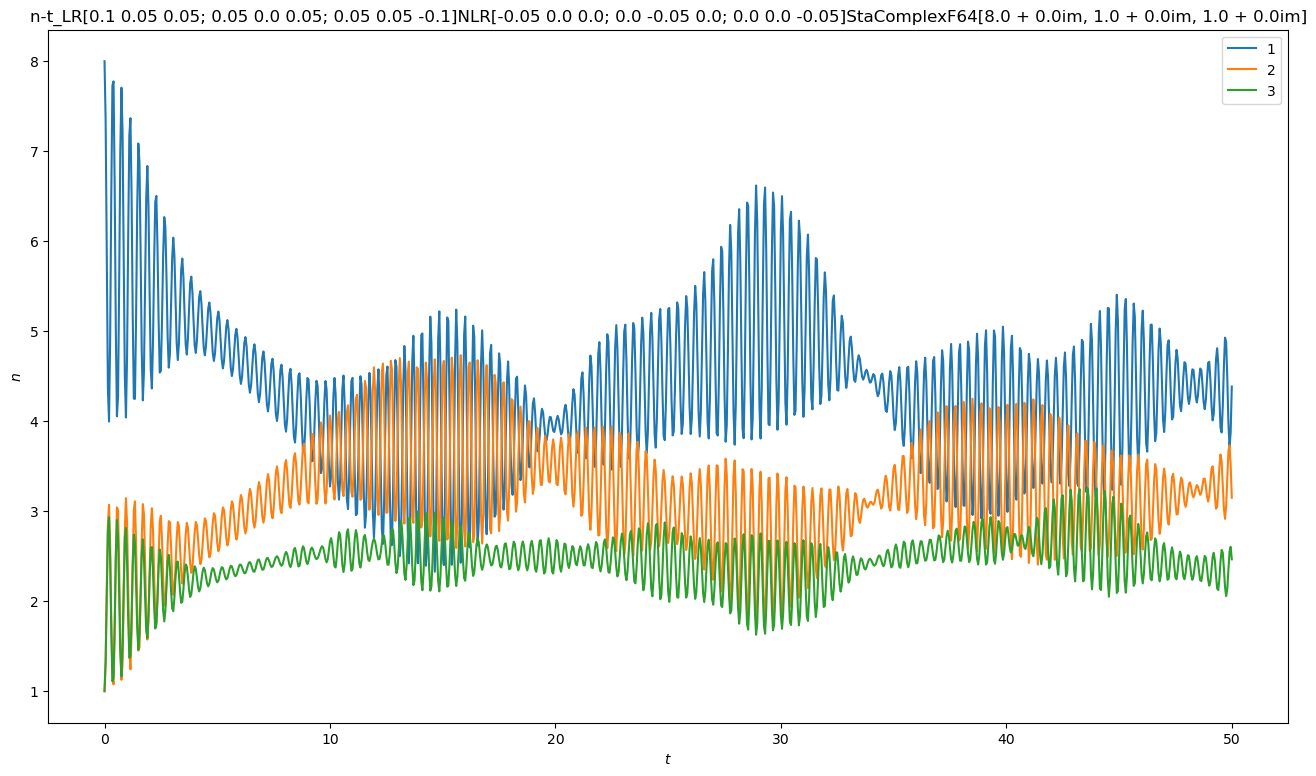

C:\Users\luiya\.julia\conda\3\lib\site-packages\matplotlib\cbook\__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


In [86]:
CoherentState!(S_3_1_10, P=[8,1,1])
Dynamics(S_3_1_10, tUnit=.05, tSpan=[0,1000]);

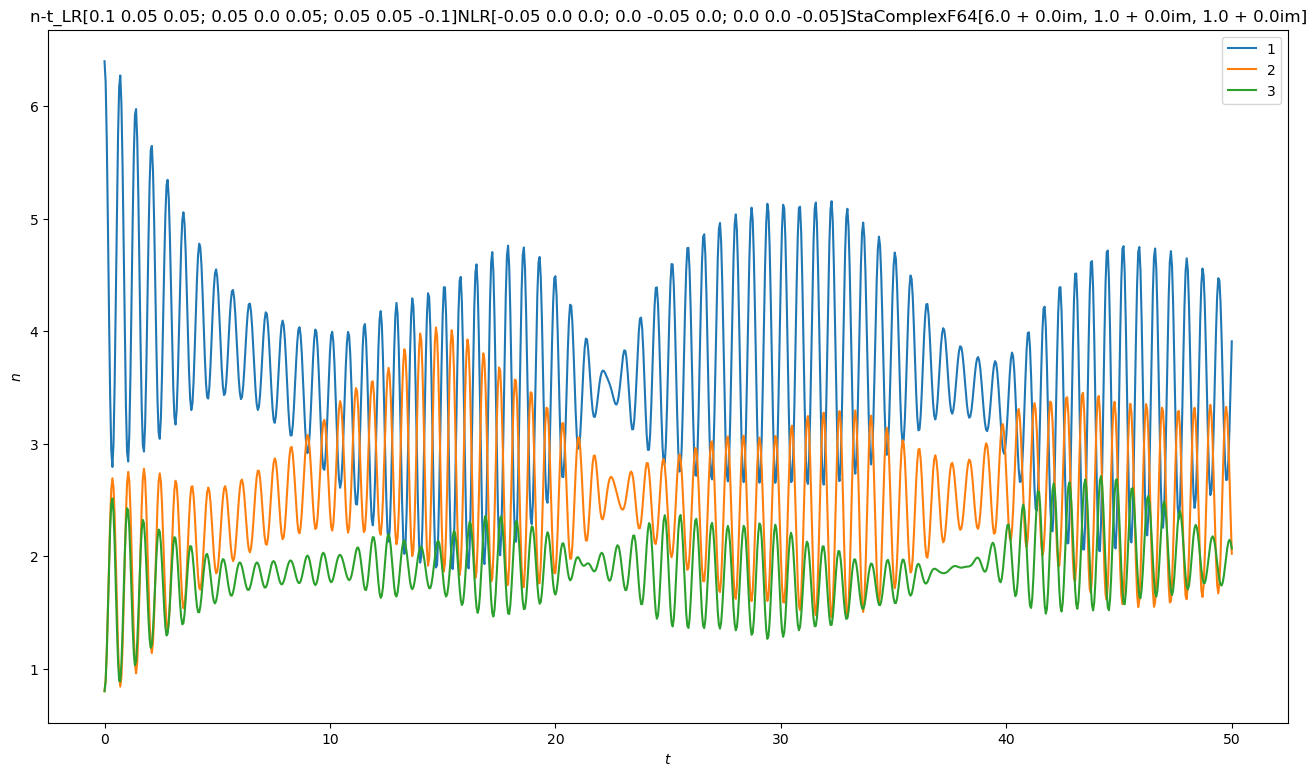

C:\Users\luiya\.julia\conda\3\lib\site-packages\matplotlib\cbook\__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


In [93]:
CoherentState!(S_3_1_8, P=[8,1,1])
Dynamics(S_3_1_8, tUnit=.05, tSpan=[0,1000]);

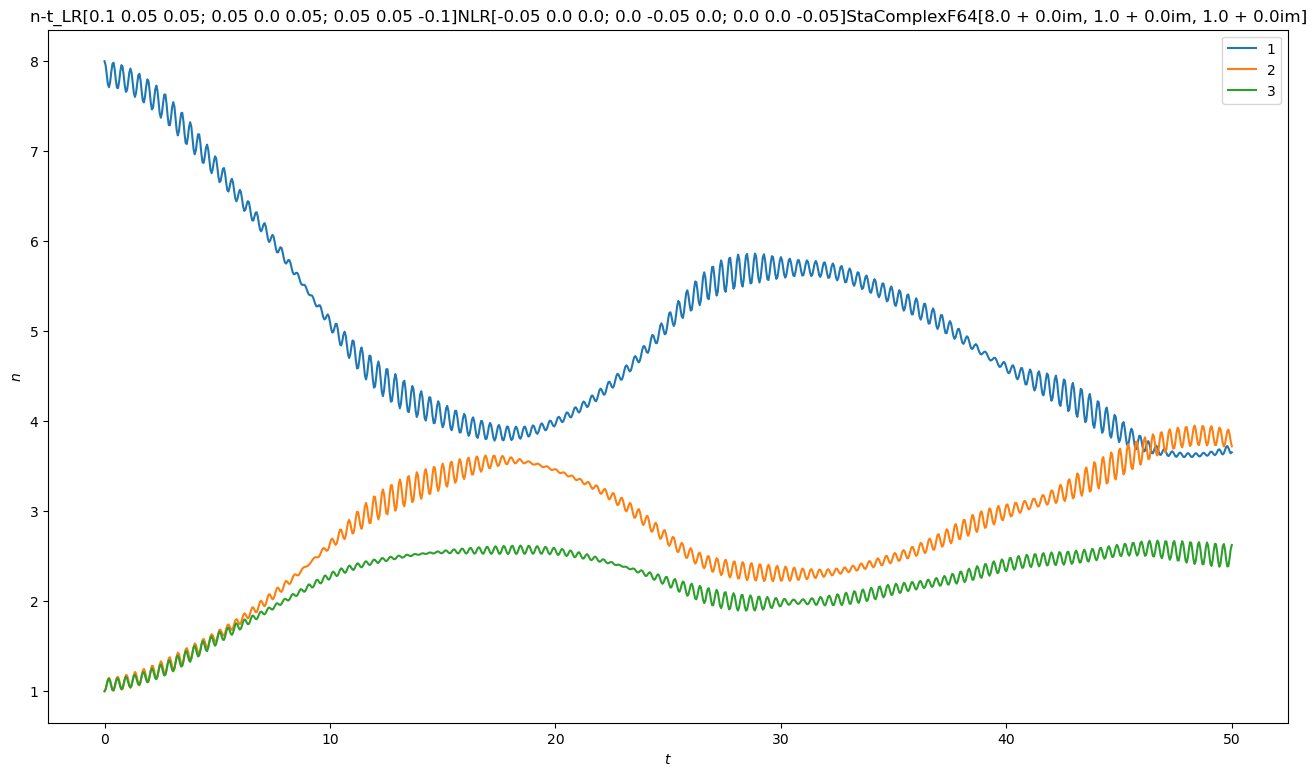

C:\Users\luiya\.julia\conda\3\lib\site-packages\matplotlib\cbook\__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


In [100]:
FockState!(S_3_1_10, [8,1,1])
Dynamics(S_3_1_10, tUnit=.05, tSpan=[0,1000]);

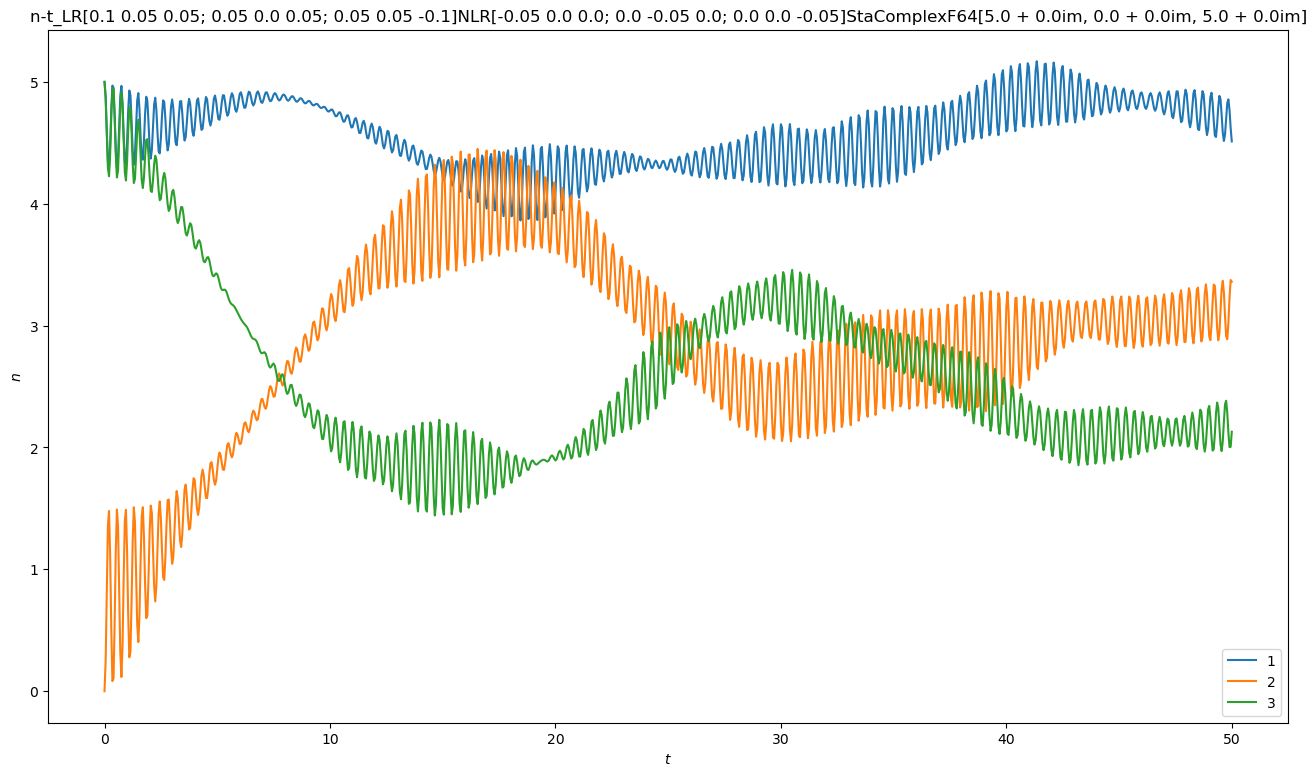

C:\Users\luiya\.julia\conda\3\lib\site-packages\matplotlib\cbook\__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


In [88]:
CoherentState!(S_3_1_10, P=[5,0,5])
Dynamics(S_3_1_10, tUnit=.05, tSpan=[0,1000]);

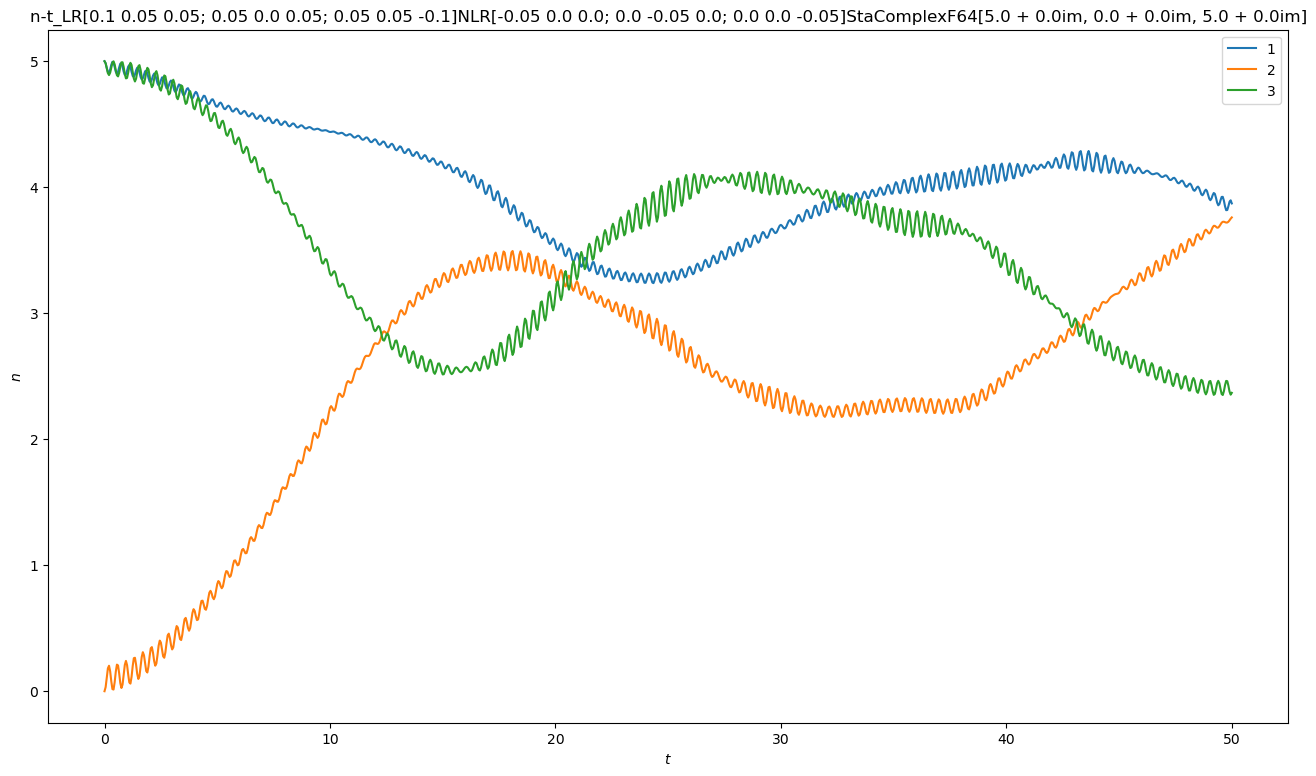

C:\Users\luiya\.julia\conda\3\lib\site-packages\matplotlib\cbook\__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


In [89]:
S_3_1_10.state .= S_3_1_10.Focki[:,findFock(S_3_1_10, [5,0,5])]
Dynamics(S_3_1_10, tUnit=.05, tSpan=[0,1000]);

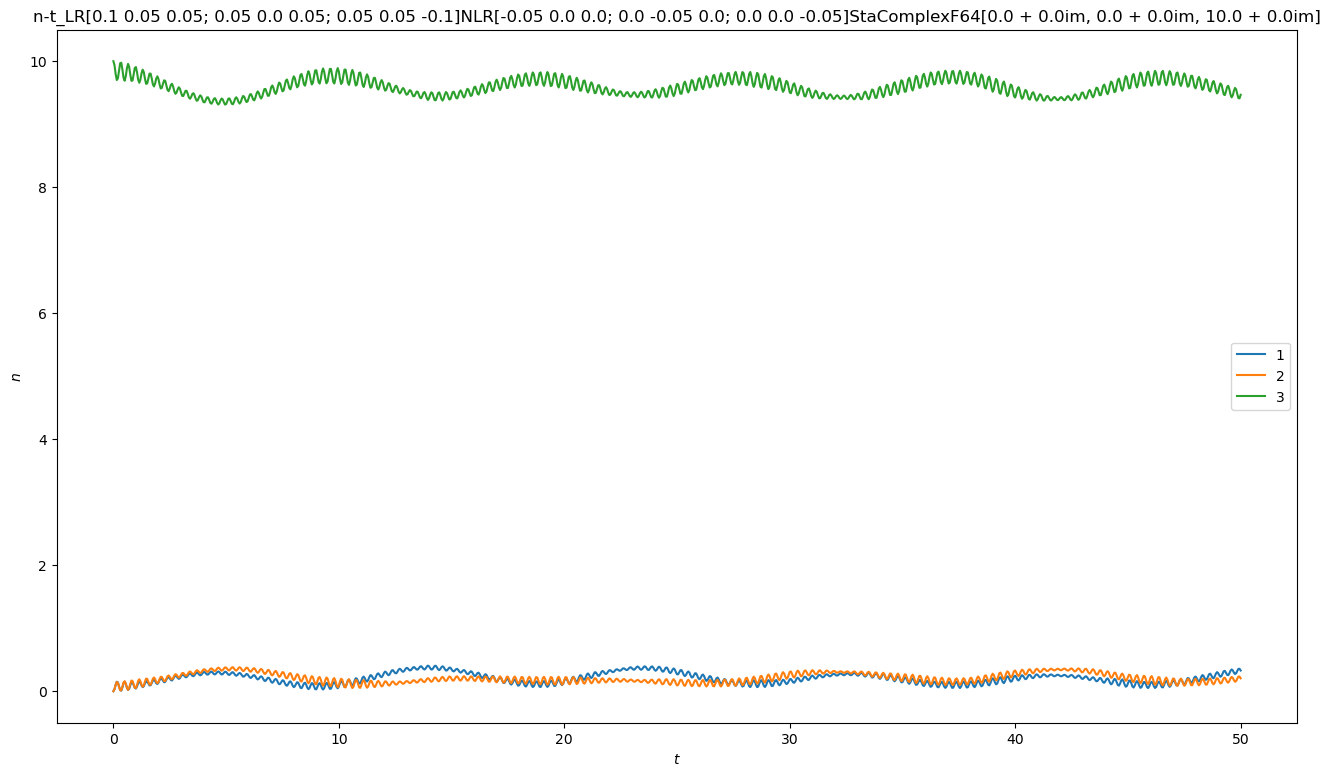

C:\Users\luiya\.julia\conda\3\lib\site-packages\matplotlib\cbook\__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


In [90]:
FockState!(S_3_1_10, [0,0,10])
Dynamics(S_3_1_10, tUnit=.05, tSpan=[0,1000]);

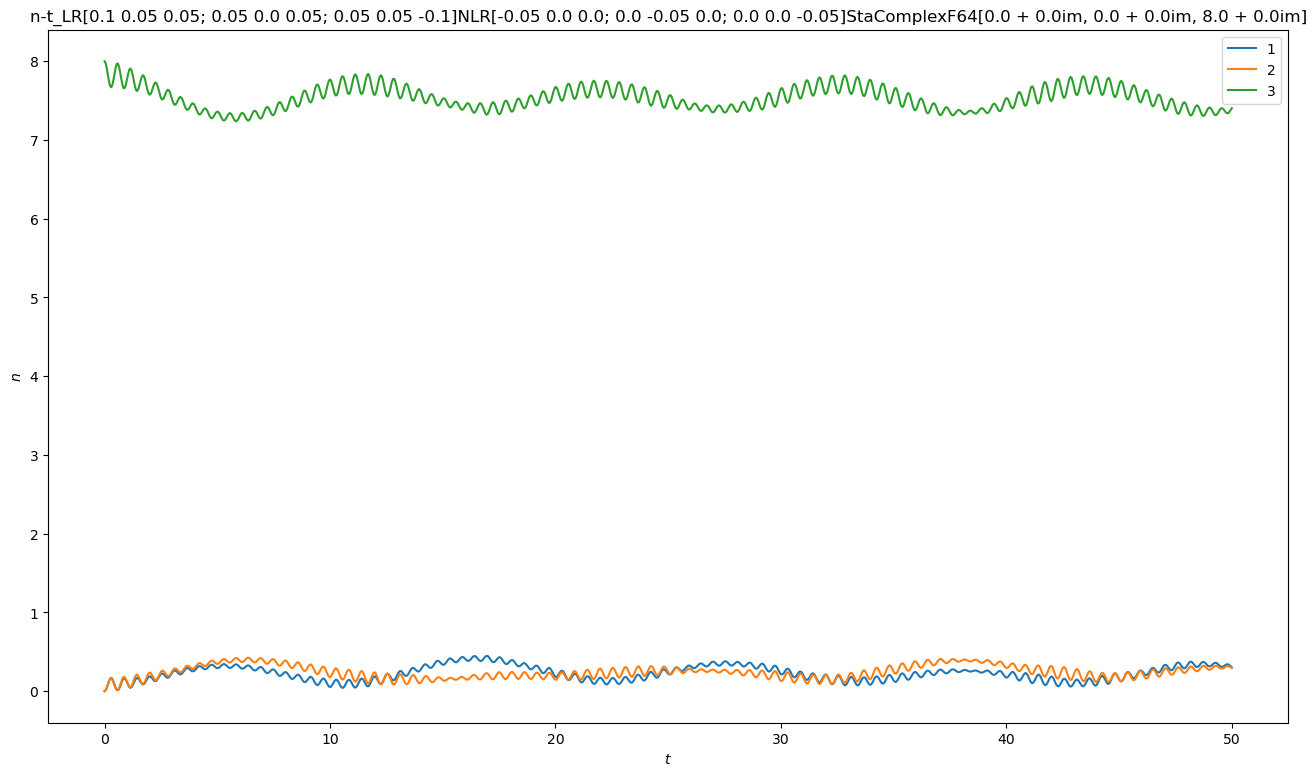

C:\Users\luiya\.julia\conda\3\lib\site-packages\matplotlib\cbook\__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


In [94]:
FockState!(S_3_1_8, [0,0,8])
Dynamics(S_3_1_8, tUnit=.05, tSpan=[0,1000]);

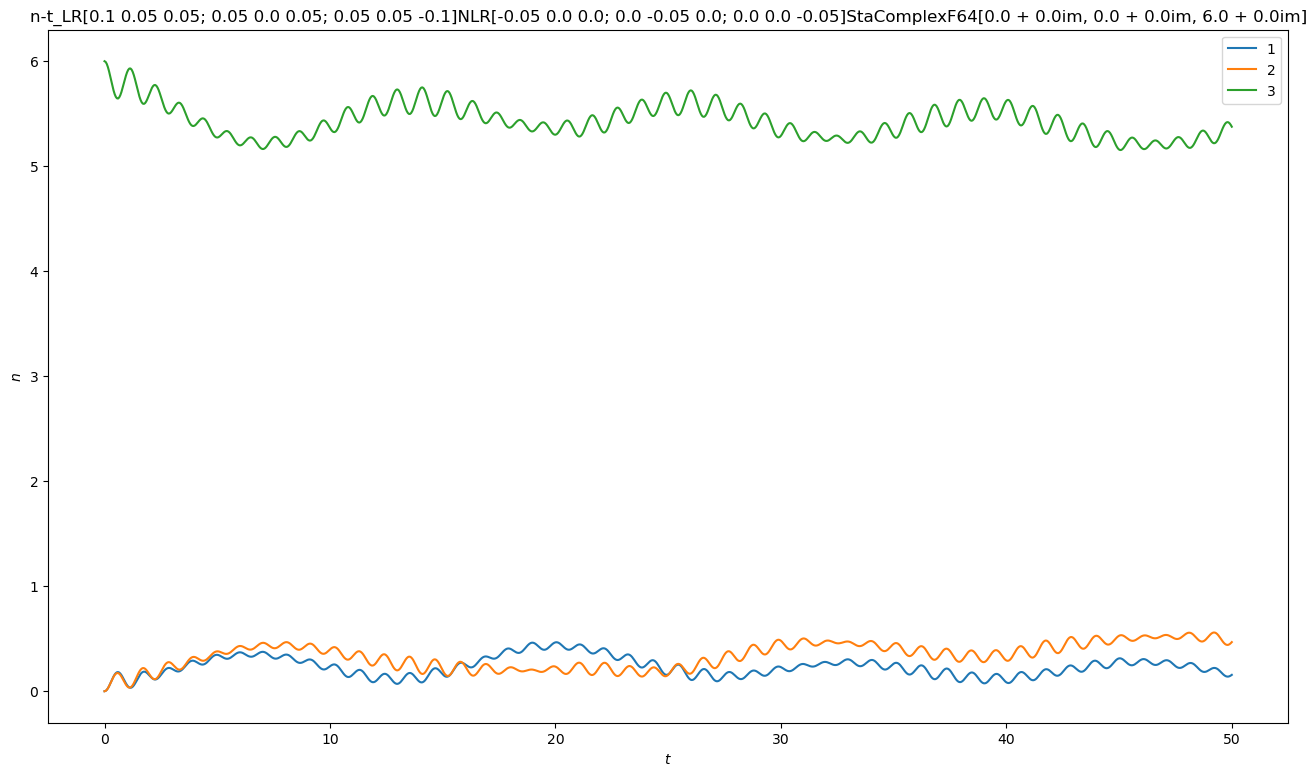

C:\Users\luiya\.julia\conda\3\lib\site-packages\matplotlib\cbook\__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


In [104]:
FockState!(S_3_1_6, [0,0,6])
Dynamics(S_3_1_6, tUnit=.05, tSpan=[0,1000]);

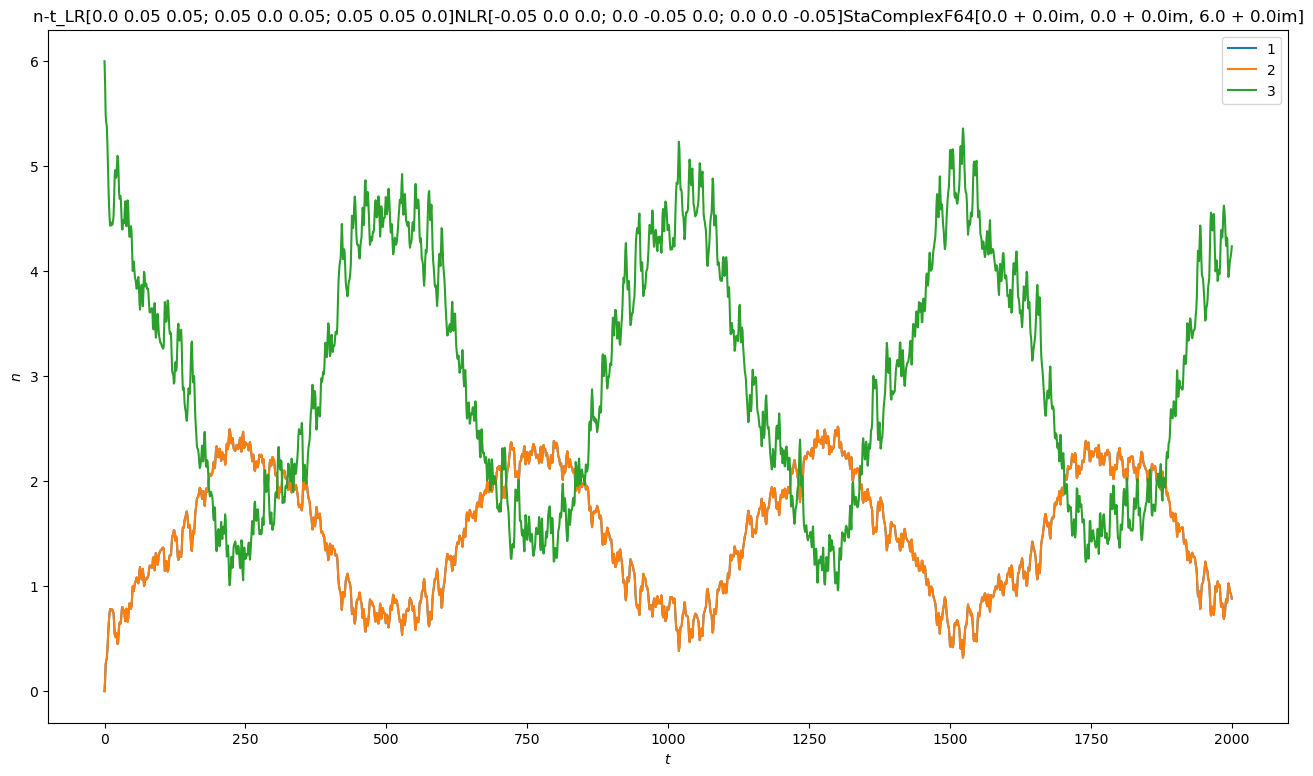

C:\Users\luiya\.julia\conda\3\lib\site-packages\matplotlib\cbook\__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


In [109]:
HforS_3_1(S_3_1_6, .1,.1,0)
FockState!(S_3_1_6, [0,0,6])
Dynamics(S_3_1_6, tUnit=1, tSpan=[0,2000]);